https://www.tensorflow.org/tutorials/generative/pix2pix

픽스투픽스와 사이클갠은 좀 알아둘 필요가 있다. 픽스 투 픽스는 이미지에서 페어를 이루어서 학습을 시키는 것이다. 짝을 이루어서 학습을 시키면 기존의 학습 결과를 이용해서 다양한 이미지를 아주 깔끔하게 생성할 수 있다. 

그럼 어떻게 짝을 이루는지 알아내는게 핵심이다. 스타일 트랜스퍼는 별개로 학습시켰다. 그런데 이것은 흑백/칼라 간략/실제 등으로 학습을 시킬 수가 있다. 이것을 잘 해두면, 흑백과 칼라를 이루어서 학습을 시키면 흑백 이미지를 칼라로 바꿀 수 있는 것이다. 참고로 gan은 generative의 약자이다. 그런데 왜 중간에 a인지는 잘 모르겠네... 텐서플로 홈페이지에 generative라고 되어 있다. 이것을 잘 보면 된다. UC Berkeley는 영상처리 관련해서 최고의 학과이다.

갠은 항상 학습이 안된다. 뭐가 안된다? 학습이 안된다. 학습을 잘 시키기 위한 많은 전략들이 있다.

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

점점 어려워지니까 항상 loss를 어떻게 정하는가가 가장 큰 문제이다. trainable false 등의 테크닉을 잘 활용해야 한다. 

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 7s 0us/step


항상 버클리 대학은 최고 대학이라 공격을 많이 받아서, 코드랑 데이터 다 공개해둔다. 근데 이 픽스투픽스도 체리피킹이다. 얘도 데이터가 많으면 좋은데, 건축 프로젝트를 한 번 한 적이 있었는데, 데이터가 없어서 스타갠, 사이클갠해서 그나마 데이터를 만들어놨다고 한다.

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2 # 나눠주는데 정수로 반환한다. 처음 알았음...
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

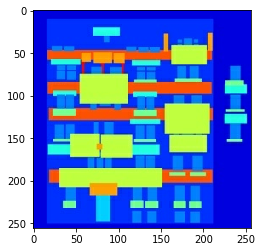

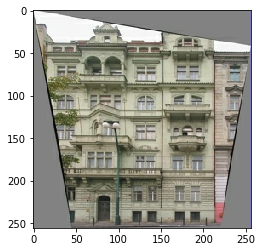

In [5]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # method는 선형보간법 옵션이다.
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [21]:
# 스택은 차원 높여준다.
import numpy as np
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.stack([a, b], axis = 0)
c.shape

(2, 3)

In [7]:
def random_crop(input_image, real_image):
    # stack은 다 좋은데, 차원을 높여줘소 좀 거슬린다.
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

클래시피케이션 문제는 다 뭘로한다? 트랜스퍼러닝으로 해결한다. 많나 작냐, 유사하냐 아니냐에 따라서 잘 해주면 된다. 그럼 디텍션만 남는데, 이건 RCNN 계열이다. 학습속도가 느리다. 그래서 이때는, 모두 텐서로 데이터 관리해주는 테크닉을 써야한다. ★★★

만약에 데이터사이언스를 계속 한다면... 상업화가 아니라, 가능성을 본다. 되는지 안되는지 테스트를 하는 것이다. 만약 된다면, 최적화는 개발자가 하면 된다. 개발자가 실력이 좋으면 좋을 수록, 최적화는 잘 되겠지. 하지만 한국에서는 일단 되는게 중요하다.

이미지 사이즈 맞춰주는 기법 2가지. 크롭과 리사이즈가 있다.

In [23]:
# -1에서 1 사이로 노말라이즈 -> 좀 더 학습이 잘되는 효과가 있다. ★★★
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

이 기법과 하이퍼볼릭 탄젠트 기법과 비슷하다. 그냥 0에서 1 사이는 시그모이드와 비슷하고 말이다. 이것 역시 activation함수에 따라서 달라진다. 

 - -1에서 1사이로 할 경우: 렐루 안쓴다 
 - 0에서 1사이로 할 경우: 렐루!

In [24]:
# tf.function 뒤에 괄호가 붙었다. -> 인자를 넣을 수 있다.
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

모델은 논문 읽어서 할 수 있는데, 항상 코드 짜는게 어렵다... 그래서 넘파이 숙제 내준거니까 연습해라.

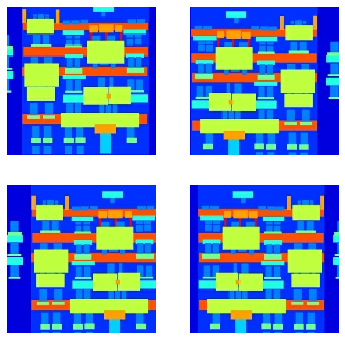

In [25]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [30]:
len(os.listdir(PATH + 'train')) # 데이터 개수가 작으므로 오그멘테이션 해야 한다.

400

tf.image 써서 오그멘테이션 해줘야 한다. 케라스에서는 이미지데이터 제너레이터가 있지만, 텐서플로에서는 그런게 없다. 그래서 로드하고 리사이즈 하고 엄청 귀찮다. 그래서 tf.image를 써줘야 하는데, 대신에 최적화를 해줄 수 있다.

In [31]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image) # augmentation
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [32]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# Input Pipeline

In [33]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [34]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

autotune은 이미지 자동으로 처리해주고, cpu 분산시켜준다. 2가지.

# Build the Generator

In [35]:
OUTPUT_CHANNELS = 3

In [36]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    # 바이어스를 안써서 좀 간단하게 만들었다.
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [37]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [38]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [39]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [40]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]

In [45]:
inputs = tf.keras.layers.Input(shape=[256,256,3])
x = inputs

In [46]:
# Downsampling through the model
skips = []
for down in down_stack:
    x = down(x)
    skips.append(x)

In [47]:
skips

[<tf.Tensor 'sequential_2/Identity:0' shape=(None, 128, 128, 64) dtype=float32>,
 <tf.Tensor 'sequential_3/Identity:0' shape=(None, 64, 64, 128) dtype=float32>,
 <tf.Tensor 'sequential_4/Identity:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'sequential_5/Identity:0' shape=(None, 16, 16, 512) dtype=float32>,
 <tf.Tensor 'sequential_6/Identity:0' shape=(None, 8, 8, 512) dtype=float32>,
 <tf.Tensor 'sequential_7/Identity:0' shape=(None, 4, 4, 512) dtype=float32>,
 <tf.Tensor 'sequential_8/Identity:0' shape=(None, 2, 2, 512) dtype=float32>,
 <tf.Tensor 'sequential_9/Identity:0' shape=(None, 1, 1, 512) dtype=float32>]

In [48]:
skips = reversed(skips[:-1])

In [49]:
skips

왜 리버스를 했을까... 

In [56]:
initializer = tf.random_normal_initializer(0., 0.02)
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh') # (bs, 256, 256, 3)

In [57]:
 up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

In [58]:
for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip]) # 이런식으로 값을 2개 받는다.

x = last(x)

<img src = 'https://www.tensorflow.org/tutorials/generative/pix2pix_files/output_dIbRPFzjmV85_0.png'>

위와 같은 구조를 U 넷이라고 한다. 자기와 대칭되는 녀석을 또 인풋으로 받았기 때문에, 훨씬 더 복원을 잘한다.

In [60]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64) # 안 된다.

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


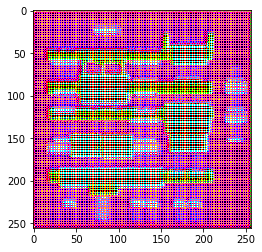

In [61]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [62]:
LAMBDA = 100

In [64]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), 
                           disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

갠에서 우리는 loss를 항상 조심해야 한다. 람다를 상수 개념으로 추가시켰다. 조절할 수 있는 뭔가가 있어야 하기 때문이다.

<img src = 'https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1'>

# Build the Discriminator

In [65]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [66]:
discriminator = Discriminator()

<img scr = 'https://www.tensorflow.org/tutorials/generative/pix2pix_files/output_YHoUui4om-Ev_0.png'>

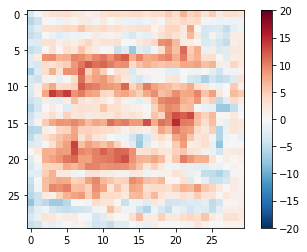

In [67]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

요즘 논문들은 근거가 있는게 아니라, 해보니까 되더라 이거다. 대신에 소스코드 있고, 데이터 다 있다. 그래서 더러우면 니가 해봐라 이다. 대신 몇 개 실험결과를 나열해두고, 좋아서 이걸 썼다 이런 식으로 흘러간다. 

커뮤니티 드리븐 리서치라는 부분이 있는데 (논문에) 이게 무서운거다. 공개해서 써봤는데, 잘됬다. 이것도 하나의 증명방식인 것이다. 많은 사람들이 사용했을 때 잘된다는 것이다.

https://arxiv.org/abs/1611.07004



In [68]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [69]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Define the Optimizers and Checkpoint-saver

In [70]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [71]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Generate Images

In [72]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

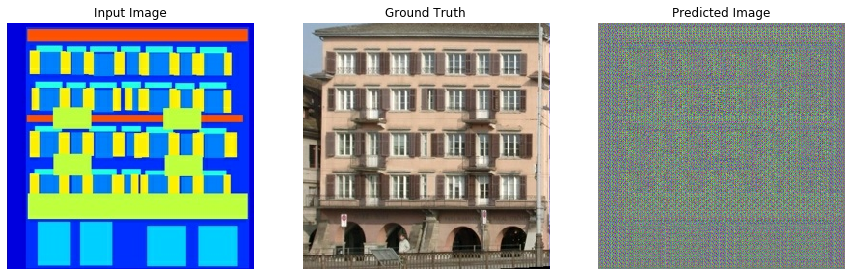

In [73]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [74]:
EPOCHS = 5

In [75]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [76]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)
    
    # apply gradient이용해서 옵티마이저에 쓸 수 있다.
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [96]:
dir(summary_writer.as_default) # as_default 이 가장 중요하다.

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__original_wrapped__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__wrapped__',
 '_tf_decorator']

In [99]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
        generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
        print('.', end='')
        if (n+1) % 100 == 0:
            print()
        train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

# 사이클 갠

https://www.tensorflow.org/tutorials/generative/cyclegan

짝이 없는 이미지를 학습시킬 때... 갠을 2개 만들어서, 그 2개가 서로서로 만들어주면서 발전하는 것이다. 논문에서 pair에서 성능이 더 좋다고 한다. 그런데 어쩔 수 없는 경우에 이걸 쓴다. 

In [106]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [107]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Input Pipeline

In [108]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

C:\Users\white\AppData\Roaming\Python\Python37\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cycle_gan downloaded and prepared to C:\Users\white\tensorflow_datasets\cycle_gan\horse2zebra\0.1.0. Subsequent calls will reuse this data.


In [109]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [110]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [111]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [112]:
def random_jitter(image):
    # resizing to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # randomly cropping to 256 x 256 x 3
    image = random_crop(image)

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

In [113]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [114]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [115]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [116]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

배치 노말라이즈 vs 인스턴스 노말라이즈

배치는 배치마다 노말라이즈 하는데, 인스턴스는 인스턴스 당 노말라이즈를 한다. 인스턴스 노말라이즈 하는 이유는 이미지마다의 고유의 특징을 반영시키기 위해서이다.

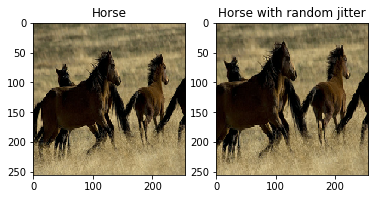

In [119]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

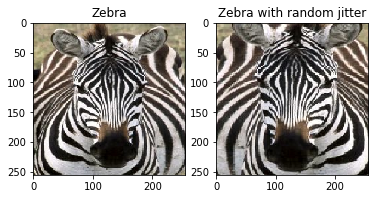

In [120]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

# Import and reuse the Pix2Pix models

In [121]:
OUTPUT_CHANNELS = 3

# norm type을 인스턴스 노말라이저로 설정했다. 
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

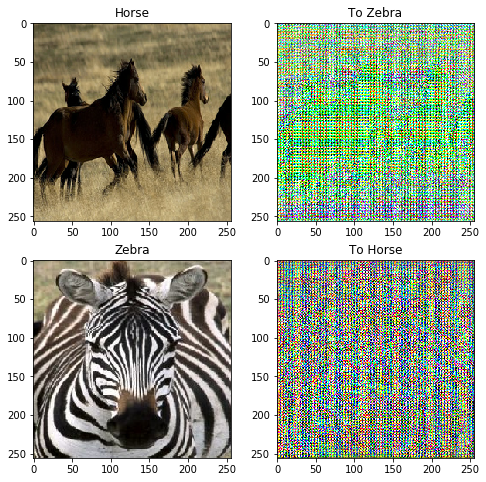

In [122]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

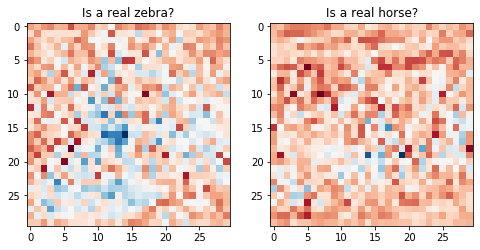

In [123]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss functions

좀 많다..

In [124]:
LAMBDA = 10

In [125]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [126]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [127]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [128]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [129]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [130]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints

In [131]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

# Training

In [132]:
EPOCHS = 10

In [133]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))